In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from unet3d import Unet3D
from diffuser import GaussianDiffusion
from data import NaiverStokes_Dataset

In [2]:
ds = NaiverStokes_Dataset('../data/ns_data_T20_v1e-03_N200.mat')

Loaded 200 samples from ../data/ns_data_T20_v1e-03_N200.mat
Shape of x: torch.Size([200, 1, 20, 64, 64])


In [3]:
model = Unet3D(
            channels=1,
            cond_channels=1,
            channel_mults=(1, 2, 4, 8, 16),
            init_conv_channels=32,
            init_conv_kernel_size=5
)

diffuser = GaussianDiffusion(
    model=model,
    sample_size=(1, 20, 64, 64),
    timesteps=1000,
    sampling_timesteps=1000,
    objective='pred_x0',
    physics_loss_weight=1.0
)
diffuser = diffuser.to('cuda:0')

In [4]:
def make_prediction(diffuser, cond, physics_loss_weight, use_res_diff):
    if use_res_diff:
        diffuser.model.load_state_dict(torch.load(f"./ckpts/ns_{physics_loss_weight:.2f}phyloss_resdiff/ckpt.pt", map_location={'cuda:1': 'cuda:0'})['model_state_dict'])
    else:
        diffuser.model.load_state_dict(torch.load(f"./ckpts/ns_{physics_loss_weight:.2f}phyloss/ckpt.pt", map_location={'cuda:1': 'cuda:0'})['model_state_dict'])
    x_pred = diffuser.sample(cond)

    return x_pred.cpu().numpy().squeeze()

In [9]:
x = ds[0]['x']
y = ds[0]['y']

In [6]:
x.shape

torch.Size([1, 20, 64, 64])

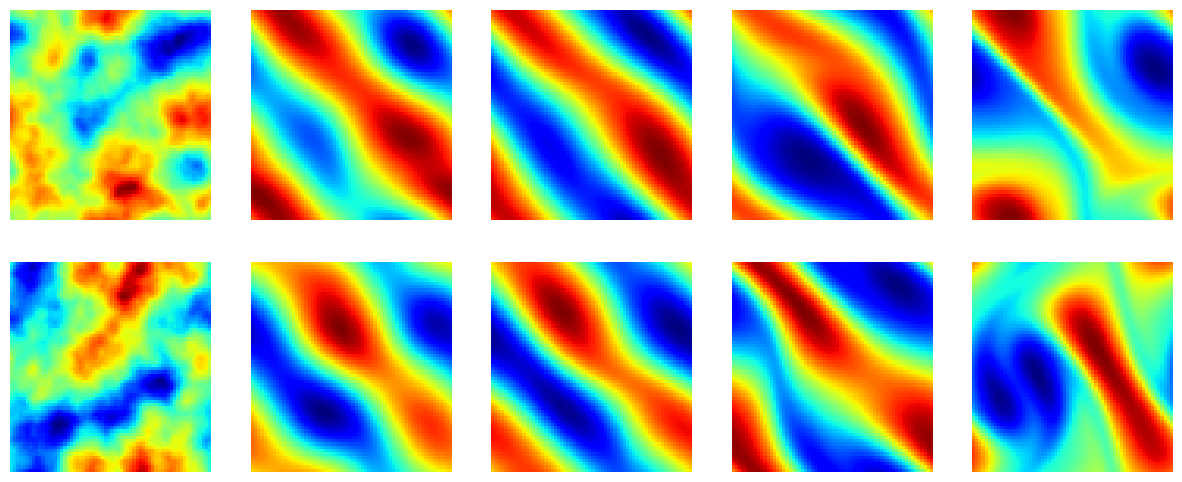

In [7]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
ax[0, 0].imshow(y[0, 0, :, :], cmap='jet', origin='lower', aspect='auto')
ax[0, 0].set_axis_off()
ax[1, 0].imshow(y[1, 0, :, :], cmap='jet', origin='lower', aspect='auto')
ax[1, 0].set_axis_off()
for i in range(1, 5):
    ax[0, i].imshow(x[0, 0, (i*5-1), :, :], cmap='jet', origin='lower', aspect='auto')
    ax[0, i].set_axis_off()
    ax[1, i].imshow(x[1, 0, (i*5-1), :, :], cmap='jet', origin='lower', aspect='auto')
    ax[1, i].set_axis_off()

In [12]:
x_pred000 = make_prediction(diffuser, y.unsqueeze(0), 0.0, False)
x_pred010 = make_prediction(diffuser, y.unsqueeze(0), 0.1, False)
x_pred020 = make_prediction(diffuser, y.unsqueeze(0), 0.2, False)
x_pred050 = make_prediction(diffuser, y.unsqueeze(0), 0.5, False)
x_pred100 = make_prediction(diffuser, y.unsqueeze(0), 1.0, False)
x_pred000_cal = x_pred000
x_pred010_cal = make_prediction(diffuser, y.unsqueeze(0), 0.1, True)
x_pred020_cal = make_prediction(diffuser, y.unsqueeze(0), 0.2, True)
x_pred050_cal = make_prediction(diffuser, y.unsqueeze(0), 0.5, True)
x_pred100_cal = make_prediction(diffuser, y.unsqueeze(0), 1.0, True)

KeyboardInterrupt: 

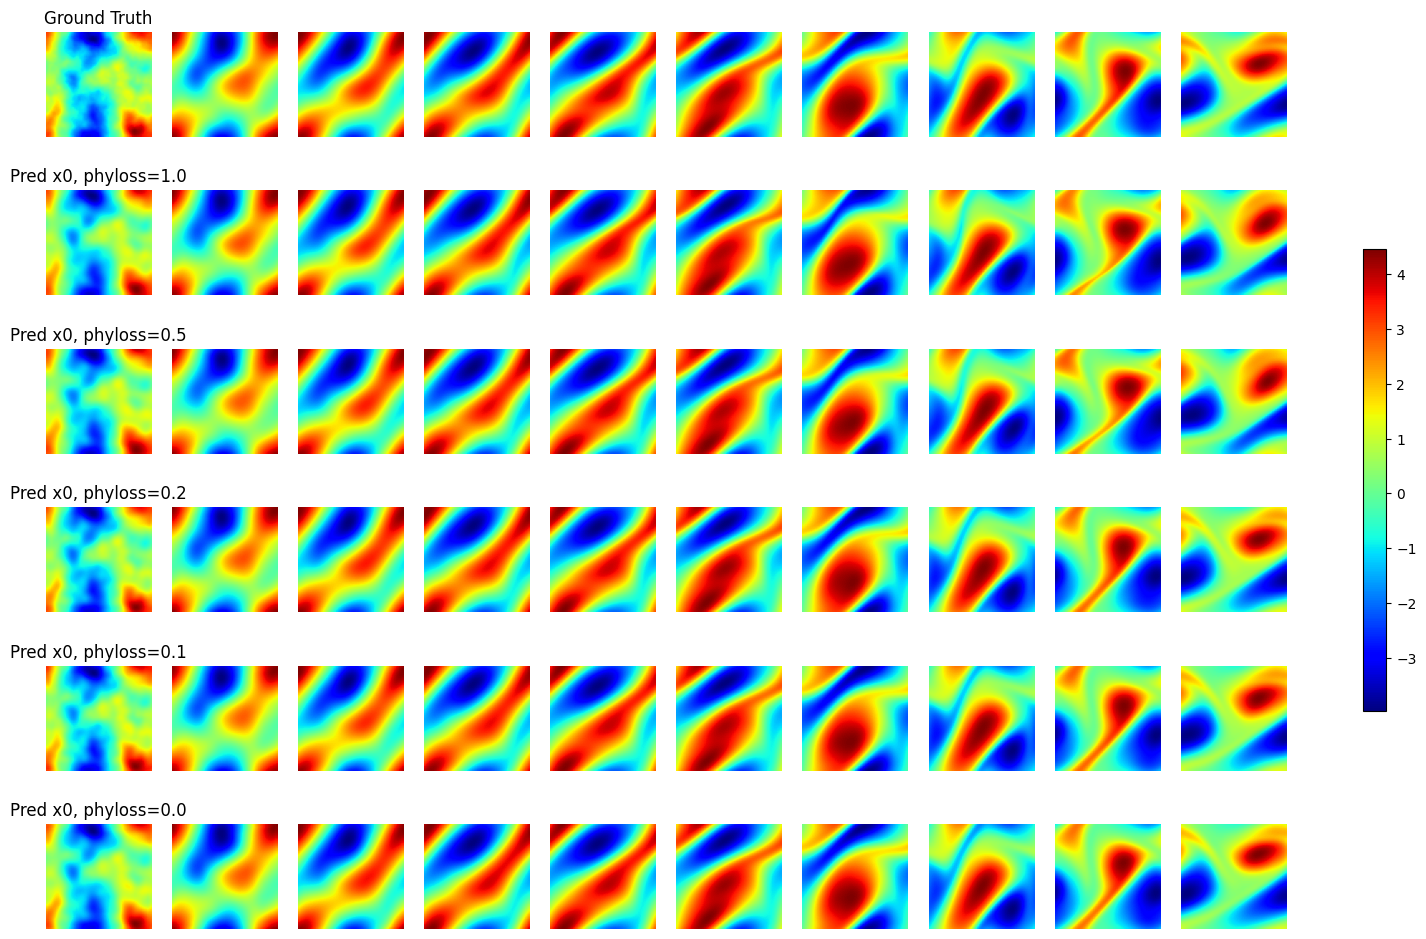

In [25]:
fig, ax = plt.subplots(6, 10, figsize=(20, 12))
for i in range(10):
    im = ax[0, i].imshow(x[i*2], cmap='jet')
    im = ax[1, i].imshow(x_pred_1[i*2], cmap='jet')
    im = ax[2, i].imshow(x_pred_2[i*2], cmap='jet')
    im = ax[3, i].imshow(x_pred_3[i*2], cmap='jet')
    im = ax[4, i].imshow(x_pred_4[i*2], cmap='jet')
    im = ax[5, i].imshow(x_pred_5[i*2], cmap='jet')
    ax[0, i].set_axis_off()
    ax[1, i].set_axis_off()
    ax[2, i].set_axis_off()
    ax[3, i].set_axis_off()
    ax[4, i].set_axis_off()
    ax[5, i].set_axis_off()
    ax[0, 0].set_title('Ground Truth')
    ax[1, 0].set_title('Pred x0, phyloss=1.0')
    ax[2, 0].set_title('Pred x0, phyloss=0.5')
    ax[3, 0].set_title('Pred x0, phyloss=0.2')
    ax[4, 0].set_title('Pred x0, phyloss=0.1')
    ax[5, 0].set_title('Pred x0, phyloss=0.0')
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)


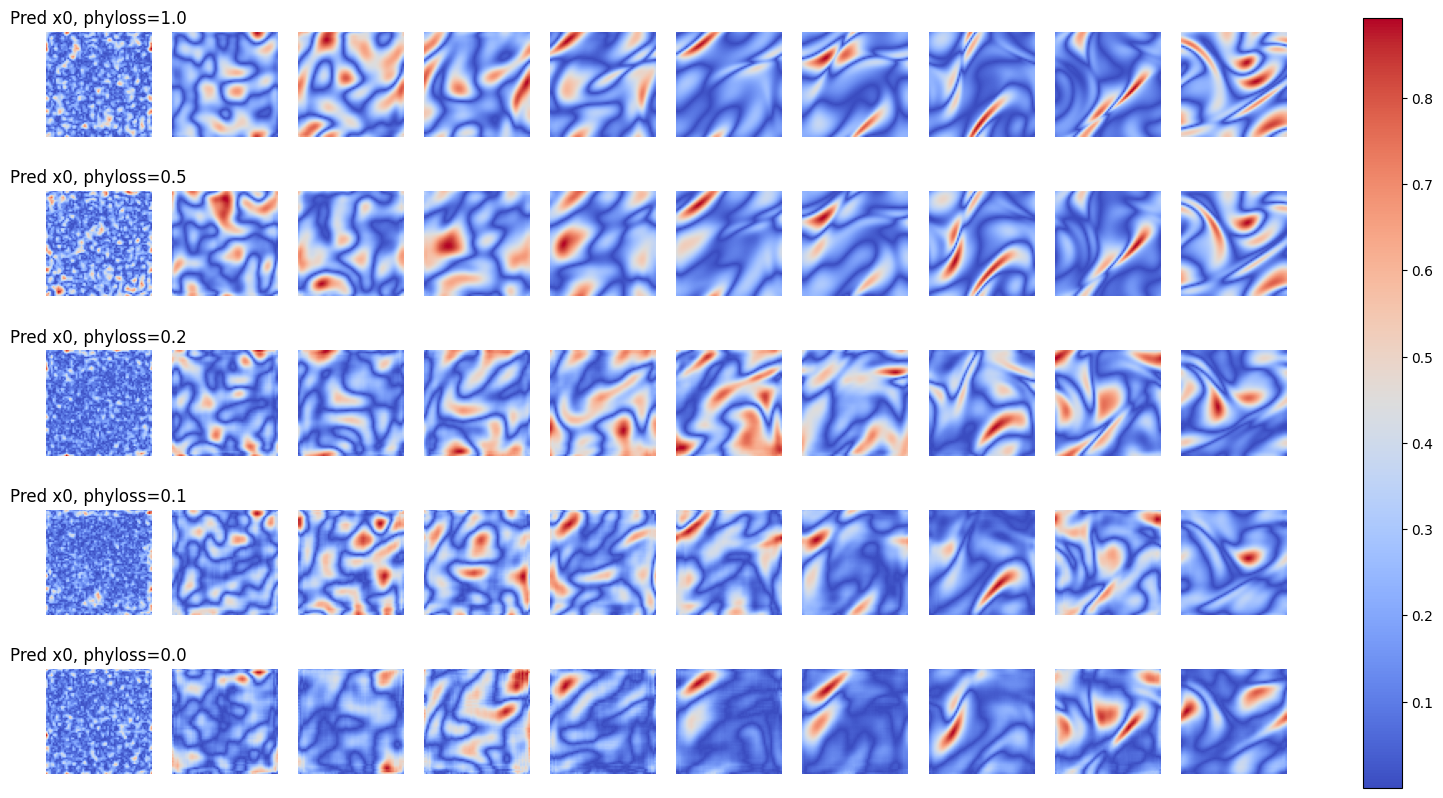

In [26]:
fig, ax = plt.subplots(5, 10, figsize=(20, 10))
for i in range(10):
    im = ax[0, i].imshow(torch.abs(x[i*2] - x_pred_1[i*2]), cmap='coolwarm')
    im = ax[1, i].imshow(torch.abs(x[i*2] - x_pred_2[i*2]), cmap='coolwarm')
    im = ax[2, i].imshow(torch.abs(x[i*2] - x_pred_3[i*2]), cmap='coolwarm')
    im = ax[3, i].imshow(torch.abs(x[i*2] - x_pred_4[i*2]), cmap='coolwarm')
    im = ax[4, i].imshow(torch.abs(x[i*2] - x_pred_5[i*2]), cmap='coolwarm')
    ax[0, i].set_axis_off()
    ax[1, i].set_axis_off()
    ax[2, i].set_axis_off()
    ax[3, i].set_axis_off()
    ax[4, i].set_axis_off()
    ax[0, 0].set_title('Pred x0, phyloss=1.0')
    ax[1, 0].set_title('Pred x0, phyloss=0.5')
    ax[2, 0].set_title('Pred x0, phyloss=0.2')
    ax[3, 0].set_title('Pred x0, phyloss=0.1')
    ax[4, 0].set_title('Pred x0, phyloss=0.0')
fig.colorbar(im, ax=ax.ravel().tolist())